# Here you would need to create a model which assigns a customer to a certain customer category based on the total value of orders they’ve placed. This would let us target the most valuable customers with certain offers which promote a higher spend.

# Importing Libraries

In [91]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import chart_studio as cs
import plotly.offline as po
import plotly.graph_objs as gobj
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Loading the Dataset

In [6]:
df=pd.read_csv("valuable_customers(Busibud).csv")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


top 5 heads of the dataset.

In [26]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/2011 12:50,4.95,12680.0,France


Bottom 5 of the dataset.

# Analysing the Patterns in the Dataset.

In [27]:
# Checking shape
df.shape

(541909, 8)

541909 rows and 8 columns in present in the dataset.

In [7]:
# customer distribution by country
country_cust_data=df[['Country','CustomerID']].drop_duplicates()
country_cust_data.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID',ascending=False)

,Country,CustomerID
36,United Kingdom,3950
14,Germany,95
13,France,87
31,Spain,31
3,Belgium,25
33,Switzerland,21
27,Portugal,19
19,Italy,15
12,Finland,12
1,Austria,11


So most of the customers are from United Kingdom, so we keep only United Kingdom.

In [10]:
# keep only united Kingdom data
df=df.query("Country=='United Kingdom'").reset_index(drop=True)

In [11]:
# Checking null values 
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133600
Country             0
dtype: int64

So null values are present in the dataset.

In [12]:
# Treating null values
df.dropna(axis=0,inplace=True)

In [13]:
# Checking null values again
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Null values treated.

In [15]:
# validating if negative values are present in UnitPrice column
df.UnitPrice.min()

0.0

In [16]:
# Filtering out records with negative values
df=df[(df['Quantity']>0)]

In [17]:
# Converting InvoiceDate to datetime
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])

In [18]:
# adding new column total amount
df['TotalAmount']=df['Quantity']=df['UnitPrice']

In [19]:
# checking shape after cleaning the data
df.shape

(354345, 9)

Now we have 354345 rows and 9 columns are present in the dataset.

In [20]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2.55,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2.55
1,536365,71053,WHITE METAL LANTERN,3.39,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,3.39
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,2.75,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2.75
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,3.39,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,3.39
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,3.39,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,3.39


# RFM Modelling

In [25]:
import datetime as dt

#Last invoice date
Latest_Date=dt.datetime(2011,12,10)

# rfm model for each customer
RFMScores=df.groupby('CustomerID').agg({'InvoiceDate':lambda x:(Latest_Date-x.max()).days,'InvoiceNo':lambda x: len(x), 'TotalAmount':lambda x: x.sum()})

# converting Invoice Date into type int

RFMScores['InvoiceDate']=RFMScores['InvoiceDate'].astype(int)

RFMScores.rename(columns={'InvoiceDate':'Recency',
                         'InvoiceNo':'Frequency',
                         'TotalAmount':'Monetary'},inplace=True)


RFMScores.reset_index().head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,1.04
1,12747.0,2,103,449.89
2,12748.0,0,4596,12205.60
3,12749.0,3,199,994.99
4,12820.0,3,59,112.38


In [26]:
# Statistical Analysis for Recency
RFMScores.Recency.describe()

count    3921.000000
mean       91.722265
std        99.528532
min         0.000000
25%        17.000000
50%        50.000000
75%       142.000000
max       373.000000
Name: Recency, dtype: float64

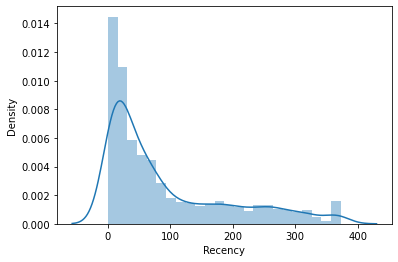

In [28]:
# Distribution Plot for Recency
x=RFMScores['Recency']
ax=sns.distplot(x)

Data is left skewed.

In [29]:
# Spliting into four segements
quantiles=RFMScores.quantile(q=[0.25,0.5,0.75])
quantiles=quantiles.to_dict()

In [30]:
# Functions for creating R, F and M
def RScoring(x,p,d):
    if x<=d[p][0.25]:
        return 1
    elif x<=d[p][0.5]:
        return 2
    elif x<= d[p][0.75]:
        return 3
    else:
        return 4
    
def FnMscoring(x,p,d):
    if x<=d[p][0.25]:
        return 4
    elif x<=d[p][0.50]:
        return 3
    elif x<= d[p][0.75]:
        return 2
    else:
        return 1

In [46]:
# Showing R, F and M values
RFMScores['R']=RFMScores['Recency'].apply(RScoring, args=('Recency',quantiles,))
RFMScores['F']=RFMScores['Frequency'].apply(FnMscoring,args=('Frequency',quantiles,))
RFMScores['M']=RFMScores['Monetary'].apply(FnMscoring,args=('Monetary',quantiles,))
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12346.0,325,1,1.04,4,4,4
12747.0,2,103,449.89,1,1,1
12748.0,0,4596,12205.60,1,1,1
12749.0,3,199,994.99,1,1,1
12820.0,3,59,112.38,1,2,3


In [50]:
# Showing combined score of RFM
RFMScores['RFMGroup']=RFMScores.R.map(str)  + RFMScores.F.map(str)+RFMScores.M.map(str)

# Showing total sum of RFMGroup
RFMScores['RFMScore']=RFMScores[['R','F','M']].sum(axis=1)
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore
CustomerID,,,,,,,,
12346.0,325,1,1.04,4,4,4,444,12
12747.0,2,103,449.89,1,1,1,111,3
12748.0,0,4596,12205.60,1,1,1,111,3
12749.0,3,199,994.99,1,1,1,111,3
12820.0,3,59,112.38,1,2,3,123,6


In [52]:
# Now Assigning  Loyality Level to each customer
Loyality_Level=['Platinum','Gold','Silver','Broonze']
Score_cuts=pd.qcut(RFMScores.RFMScore, q=4, labels=Loyality_Level)
RFMScores['RFM_Loyality_Level']=Score_cuts.values
RFMScores.reset_index().head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyality_Level
0,12346.0,325,1,1.04,4,4,4,444,12,Broonze
1,12747.0,2,103,449.89,1,1,1,111,3,Platinum
2,12748.0,0,4596,12205.60,1,1,1,111,3,Platinum
3,12749.0,3,199,994.99,1,1,1,111,3,Platinum
4,12820.0,3,59,112.38,1,2,3,123,6,Gold


In [54]:
# Now validating the data for RFMGroup
RFMScores[RFMScores['RFMGroup']=='111'].sort_values('Monetary',ascending=False).reset_index().head(10)

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyality_Level
0,14096.0,4,5111,33332.45,1,1,1,111,3,Platinum
1,17841.0,1,7847,19848.49,1,1,1,111,3,Platinum
2,12748.0,0,4596,12205.60,1,1,1,111,3,Platinum
3,14606.0,1,2700,7595.75,1,1,1,111,3,Platinum
4,15311.0,0,2379,5961.86,1,1,1,111,3,Platinum
5,14527.0,2,972,5207.70,1,1,1,111,3,Platinum
6,13089.0,2,1818,4977.35,1,1,1,111,3,Platinum
7,15039.0,9,1502,4757.67,1,1,1,111,3,Platinum
8,15502.0,15,213,4193.96,1,1,1,111,3,Platinum
9,16033.0,5,1137,3803.64,1,1,1,111,3,Platinum


Now we can see the Loyality level of the individual customer.

# Now Plotting the segements on Graph

In [66]:
# Recency Vs Frequency
graph= RFMScores.query("Monetary <50000 and Frequency <2000")


In [78]:
plot_data=[
    gobj.Scatter(x=graph.query("RFM_Loyality_Level=='Bronze'")['Recency'],
                      y=graph.query("RFM_Loyality_Level=='Bronze'")['Frequency'],
                      mode='markers',
                      name='Bronze',
                      marker=dict(size=7,
                                 line=dict(width=1),
                                 color='blue',
                                  opacity=0.8
                                 ,)
                ),
     gobj.Scatter(x=graph.query("RFM_Loyality_Level=='Silver'")['Recency'],
                      y=graph.query("RFM_Loyality_Level=='Silver'")['Frequency'],
                      mode='markers',
                      name='Silver',
                      marker=dict(size=9,
                                 line=dict(width=1),
                                 color='green',
                                  opacity=0.5
                                 ,)
                ),
    gobj.Scatter(x=graph.query("RFM_Loyality_Level=='Gold'")['Recency'],
                      y=graph.query("RFM_Loyality_Level=='Gold'")['Frequency'],
                      mode='markers',
                      name='Gold',
                      marker=dict(size=11,
                                 line=dict(width=1),
                                 color='red',
                                  opacity=0.9
                                  ,)
                ),
    gobj.Scatter(x=graph.query("RFM_Loyality_Level=='Platinum'")['Recency'],
                      y=graph.query("RFM_Loyality_Level=='Platinum'")['Frequency'],
                      mode='markers',
                      name='Platinum',
                      marker=dict(size=13,
                                 line=dict(width=1),
                                 color='black',
                                  opacity=0.9
                                  ,)
                ),
    
                                  
    
                 
    
    

]


In [80]:
# Now Plotting
plot_layout=gobj.Layout(yaxis={'title':'Frequency'},
                       xaxis={'title':'Recency'},
                       title='Segments')

fig=gobj.Figure(data=plot_data,layout=plot_layout)
po.iplot(fig)


# Frequency vs Monetory

graph=RFMScores.query("Monetary<50000 and Frequency<2000")

plot_data=[
    gobj.Scatter(x=graph.query("RFM_Loyality_Level=='Bronze'")['Frequency'],
                      y=graph.query("RFM_Loyality_Level=='Bronze'")['Monetary'],
                      mode='markers',
                      name='Bronze',
                      marker=dict(size=7,
                                 line=dict(width=1),
                                 color='blue',
                                  opacity=0.8
                                 ,)
                ),
     gobj.Scatter(x=graph.query("RFM_Loyality_Level=='Silver'")['Frequency'],
                      y=graph.query("RFM_Loyality_Level=='Silver'")['Monetary'],
                      mode='markers',
                      name='Silver',
                      marker=dict(size=9,
                                 line=dict(width=1),
                                 color='green',
                                  opacity=0.5
                                 ,)
                ),
    gobj.Scatter(x=graph.query("RFM_Loyality_Level=='Gold'")['Frequency'],
                      y=graph.query("RFM_Loyality_Level=='Gold'")['Monetary'],
                      mode='markers',
                      name='Gold',
                      marker=dict(size=11,
                                 line=dict(width=1),
                                 color='red',
                                  opacity=0.9
                                  ,)
                ),
    gobj.Scatter(x=graph.query("RFM_Loyality_Level=='Platinum'")['Frequency'],
                      y=graph.query("RFM_Loyality_Level=='Platinum'")['Monetary'],
                      mode='markers',
                      name='Platinum',
                      marker=dict(size=13,
                                 line=dict(width=1),
                                 color='black',
                                  opacity=0.9
                                  ,)
                ),
    
                                  
    
                 
    
    

]

plot_layout=gobj.Layout(yaxis={'title':'Monetary'},
                       xaxis={'title':'Recency'},
                       title='Segments')

fig=gobj.Figure(data=plot_data,layout=plot_layout)
po.iplot(fig)

We can see Platinum is looking more .

# Now Building K-means clustering model


In [81]:
# handling negative and zero values

def handle_neg_n_zero(num):
    if num <=0:
        return 1
    else:
        return num
    
# Applying Handle_leg_n_Zero function to Recency and Monetory
RFMScores['Recency']=[handle_neg_n_zero(x) for x in RFMScores.Recency]
RFMScores['Monetary']=[handle_neg_n_zero(x) for x in RFMScores.Monetary]

# Performing Log Transformation to bring data into normally distributed
Log_Tfd_Data=RFMScores[['Recency','Frequency','Monetary']].apply(np.log,axis=1).round(3)


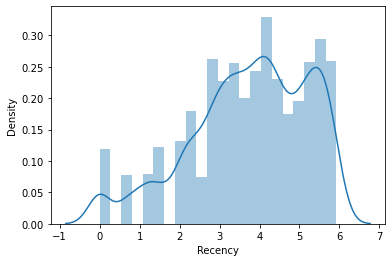

In [82]:
# Showing distribution after normalization for Recency
Recency_Plot=Log_Tfd_Data['Recency'
                         ]
ax=sns.distplot(Recency_Plot)

 Now we can see that data is closed to normal distribution in Recency.

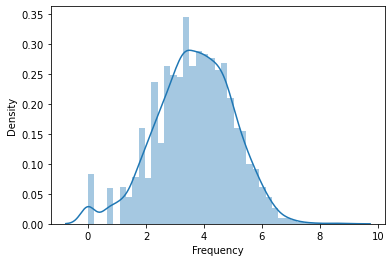

In [84]:
# Showing distribution after normalization for Frequency
Frequency_Plot=Log_Tfd_Data['Frequency'
                         ]
ax=sns.distplot(Frequency_Plot)

Now we can see that data is closed to normal distribution in Frequency.

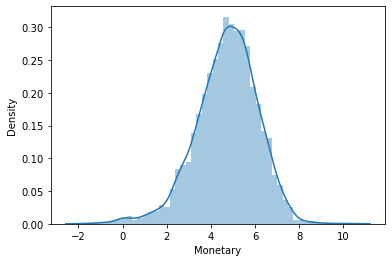

In [85]:
# Showing distribution after normalization for Monetary
Monetary_Plot=Log_Tfd_Data['Monetary'
                         ]
ax=sns.distplot(Monetary_Plot)

Now we can see that data is closed to normal distribution in Monetary.

In [89]:
# Applying Elbow method and bringing the data on same scale
scaleobj=StandardScaler()
Scaled_Data=scaleobj.fit_transform(Log_Tfd_Data)

# Transforming to dataframe
Scaled_Data=pd.DataFrame(Scaled_Data, index=RFMScores.index, columns=Log_Tfd_Data.columns)



In [104]:
sum_of_sq_dist={}
for k in range(1,15):
    km=KMeans(n_clusters=k, init='k-means++',max_iter=1000)
    km=km.fit(Scaled_Data)
    sum_of_sq_dist[k]=km.inertia_
    


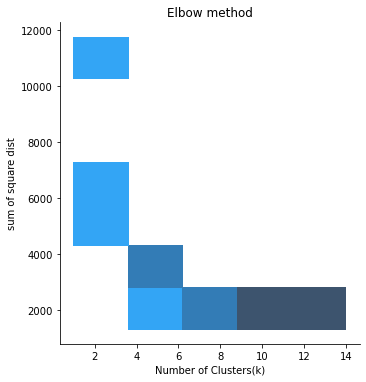

In [103]:
# Plotting the graph of sum of square values and number of clusters
sns.displot(x=list(sum_of_sq_dist.keys()),
             y=list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('sum of square dist')
plt.title('Elbow method')
        
plt.show()

 sum_of_sq_dist is decreasing at 3 so number of clusters will be 3.

# Model Building

In [107]:
KMean_clust=KMeans(n_clusters=3, init='k-means++',max_iter=1000)
KMean_clust.fit(Scaled_Data)

# Finding the clusters for the dataset
RFMScores['cluster']=KMean_clust.labels_
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyality_Level,cluster
CustomerID,,,,,,,,,,
12346.0,325,1,1.04,4,4,4,444,12,Broonze,1
12747.0,2,103,449.89,1,1,1,111,3,Platinum,0
12748.0,1,4596,12205.60,1,1,1,111,3,Platinum,0
12749.0,3,199,994.99,1,1,1,111,3,Platinum,0
12820.0,3,59,112.38,1,2,3,123,6,Gold,0


Now we can see the clusters for each customer.

<Figure size 504x504 with 0 Axes>

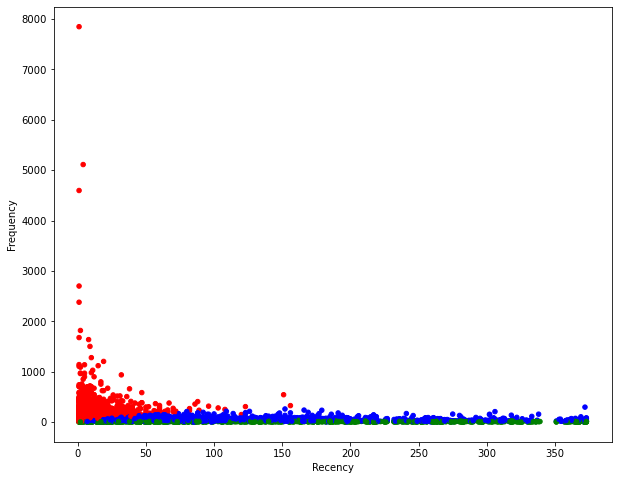

In [112]:
# Now plotting clusters through graph 
plt.figure(figsize=(7,7))

# Frequency vs Recency
colors=['red','green','blue']
RFMScores['color']=RFMScores['cluster'].map(lambda p: colors[p])
ax=RFMScores.plot(
    kind='scatter',
    x='Recency',
    y='Frequency',
    figsize=(10,8),
    c=RFMScores['color']
)



In [113]:
RFMScores

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyality_Level,cluster,color
CustomerID,,,,,,,,,,,
12346.0,325,1,1.04,4,4,4,444,12,Broonze,1,green
12747.0,2,103,449.89,1,1,1,111,3,Platinum,0,red
12748.0,1,4596,12205.60,1,1,1,111,3,Platinum,0,red
12749.0,3,199,994.99,1,1,1,111,3,Platinum,0,red
12820.0,3,59,112.38,1,2,3,123,6,Gold,0,red
...,...,...,...,...,...,...,...,...,...,...,...
18280.0,277,10,47.65,4,4,4,444,12,Broonze,1,green
18281.0,180,7,39.36,4,4,4,444,12,Broonze,1,green
18282.0,7,12,62.39,1,4,3,143,8,Gold,2,blue


# Conclusion

So from the above Figure we can see that Green is assigned to Broonze, Blue is assigned to Gold and Red is assigned to Platinum and silver is less.

# Saving the Data into csv file

In [114]:
RFMScores.to_csv('valuable_customersimp.csv')